# MNISTで多クラス分類

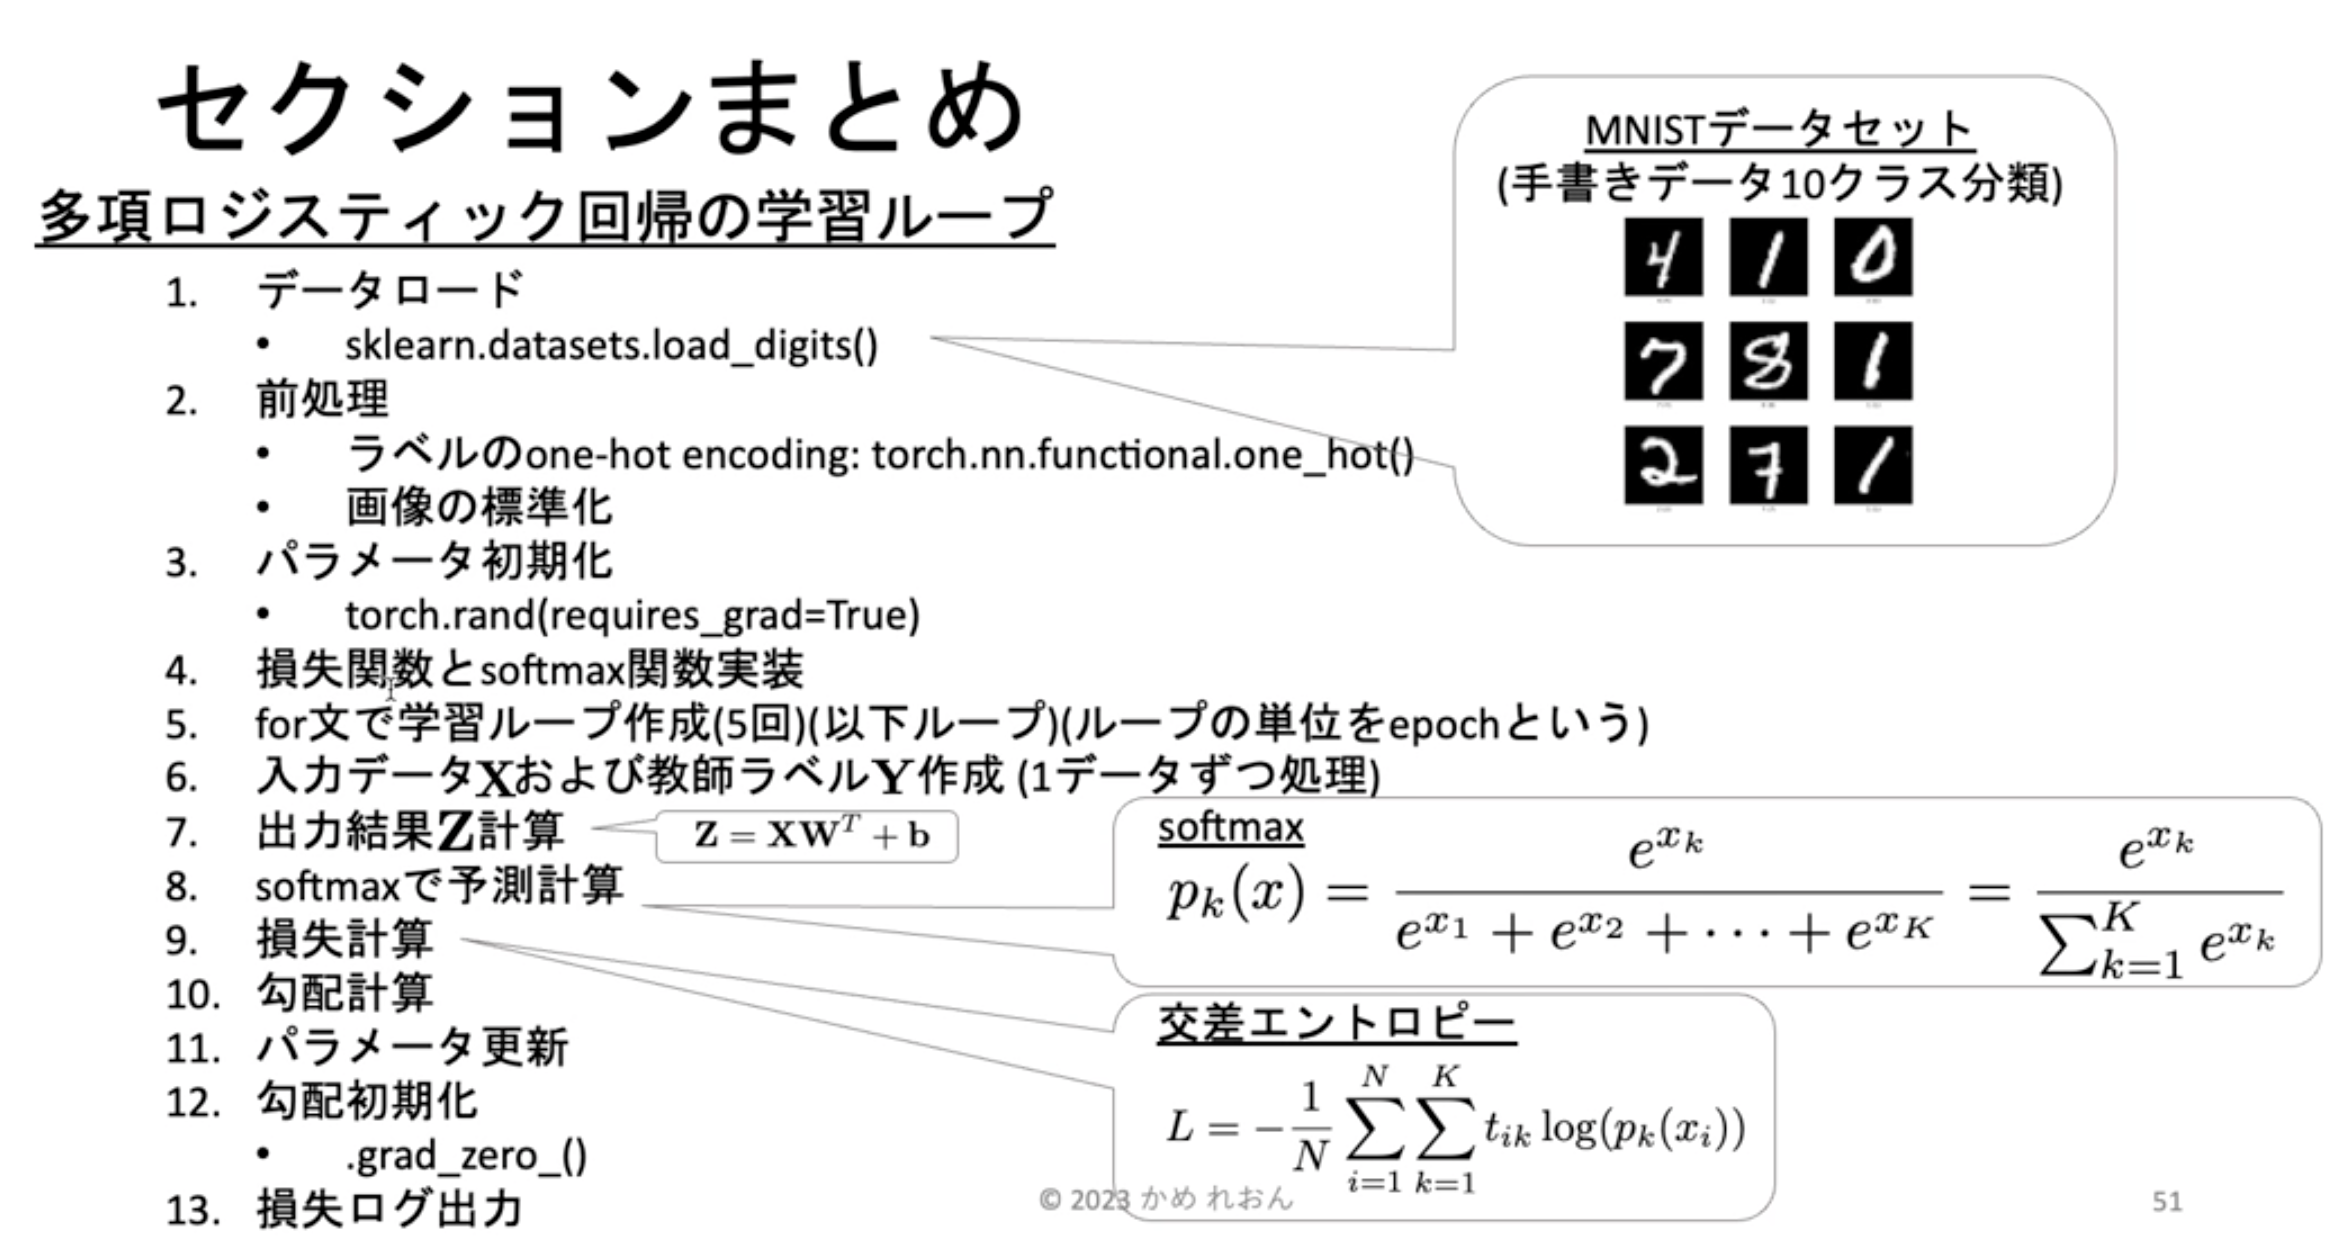

In [30]:
import torch
import numpy as np
from sklearn import datasets

## データロード

In [31]:
dataset = datasets.load_digits()
images = dataset['images']
target = dataset['target']

In [32]:
# imagesの中には、8x8ピクセルの画像が1797個入っている
images.shape

(1797, 8, 8)

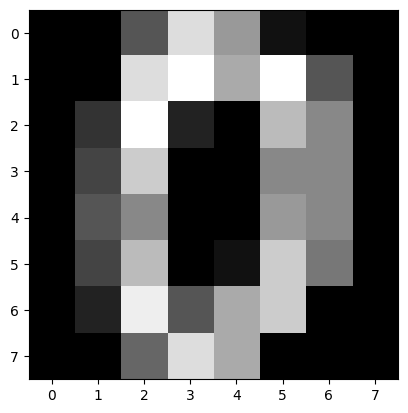

In [33]:
# 実際にどういう画像が入っているか、0番目の画像を見てみる
import matplotlib.pyplot as plt
plt.imshow(images[0], cmap='gray')

In [34]:
target.shape

(1797,)

In [35]:
target

array([0, 1, 2, ..., 8, 9, 8])

## 前処理

### ターゲットラベルのone hot encoding

In [37]:
images[0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

In [38]:
from torch.nn import functional as F
# ｔａｒｇｅｔのonehotでラベル化
y_true = F.one_hot(torch.tensor(target), num_classes=10)  # 0~9までの10クラス分類なので、num_classes=10とする
# imagesのtensor化
# Numpyのデフォルトはfloat64、torchはfloat32なので、演算時エラーになるのでfloat32に揃える
images = torch.tensor(images, dtype=torch.float32).reshape(-1, 64)

In [39]:
images[0]

tensor([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10., 15.,
         5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4., 12.,  0.,
         0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.,  0.,  4.,
        11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5., 10., 12.,  0.,  0.,
         0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [40]:
images.shape

torch.Size([1797, 64])

In [41]:
y_true

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 1, 0]])

In [42]:
y_true.shape

torch.Size([1797, 10])

### 画像の標準化

In [43]:
images = (images - images.mean()) / images.std()

In [44]:
images[0]

tensor([-0.8118, -0.8118,  0.0193,  1.3489,  0.6841, -0.6456, -0.8118, -0.8118,
        -0.8118, -0.8118,  1.3489,  1.6813,  0.8503,  1.6813,  0.0193, -0.8118,
        -0.8118, -0.3131,  1.6813, -0.4794, -0.8118,  1.0165,  0.5179, -0.8118,
        -0.8118, -0.1469,  1.1827, -0.8118, -0.8118,  0.5179,  0.5179, -0.8118,
        -0.8118,  0.0193,  0.5179, -0.8118, -0.8118,  0.6841,  0.5179, -0.8118,
        -0.8118, -0.1469,  1.0165, -0.8118, -0.6456,  1.1827,  0.3517, -0.8118,
        -0.8118, -0.4794,  1.5151,  0.0193,  0.8503,  1.1827, -0.8118, -0.8118,
        -0.8118, -0.8118,  0.1855,  1.3489,  0.8503, -0.8118, -0.8118, -0.8118])

In [45]:
learning_rate = 0.03
loss_log = []

## パラメータ初期化

In [46]:
W = torch.rand((10, 64), requires_grad=True)  # 出力 x 入力
b = torch.rand((1, 10), requires_grad=True)  # 1 x 出力

## Softmaxと交差エントロピーの関数の実装

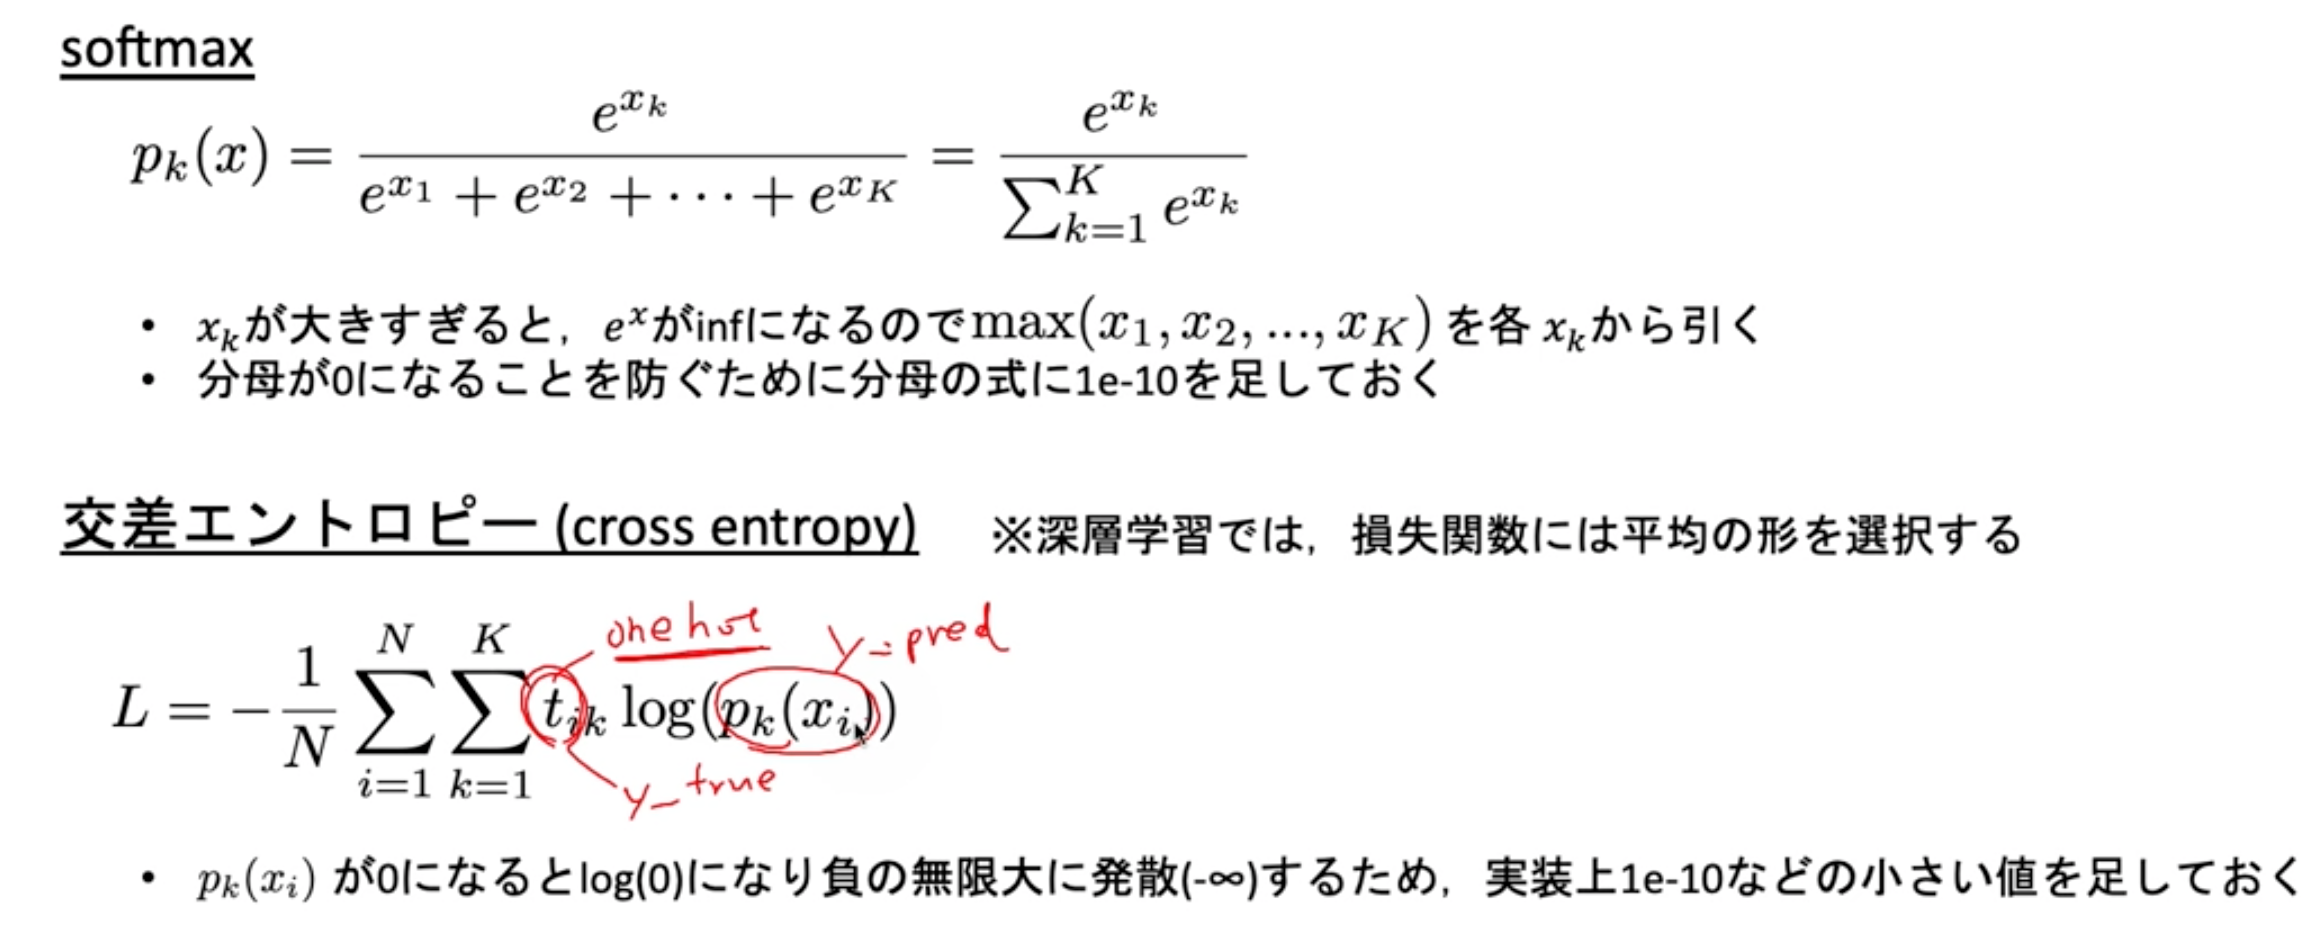

In [47]:
def softmax(x):
    e_x = torch.exp(x - torch.max(x, dim=-1, keepdim=True)[0])  # 分子
    sum_e_x = torch.sum(e_x, dim=-1, keepdim=True) + 1e-10  # 分母
    return e_x / sum_e_x

def cross_entropy(y_true, y_pred):
    return -torch.sum(y_true * torch.log(y_pred + 1e-10)) / y_true.shape[0]

In [48]:
# torch.max(a, dim=-1, keepdim=True)[0] の動きを確認する
a = torch.rand((3, 5))
print(a)
print('--------------')
print(torch.max(a, dim=-1, keepdim=True)[0])
print('--------------')
print(torch.sum(a, dim=-1, keepdim=True))

tensor([[0.1680, 0.9476, 0.8355, 0.8754, 0.5068],
        [0.5224, 0.3330, 0.0939, 0.4959, 0.9113],
        [0.6291, 0.8422, 0.0246, 0.5660, 0.6220]])
--------------
tensor([[0.9476],
        [0.9113],
        [0.8422]])
--------------
tensor([[3.3334],
        [2.3564],
        [2.6839]])


## for文で学習ループを作成

In [49]:
# for文で学習ループ作成
for epoch in range(5):
    running_loss = 0
    for i in range(len(target)):
        # 入力データXおよび教師ラベルのYを作成
        y_true_ = y_true[i].reshape(-1, 10) # データ数xクラス数
        X = images[i].reshape(-1, 64) # データ数x特徴量数
        
        # 出力結果Zの計算(Z=X*W^t+b)
        Z = X@W.T + b  # 行列の積は@演算子を使う

        # softmaxで予測計算
        y_pred = softmax(Z)

        # 損失計算
        loss = cross_entropy(y_true_, y_pred)
        loss_log.append(loss.item())  # lossはtensorの形になっているので.itemで値だけ取るようにする
        running_loss += loss.item()

        # 勾配計算
        loss.backward()

        # パラメータ更新
        with torch.no_grad():
            W -= learning_rate * W.grad
            b -= learning_rate * b.grad

        # 勾配初期化
        W.grad.zero_()
        b.grad.zero_()

    # 損失ログの出力
    print(f'epoch {epoch+1}: {running_loss/len(target)} ')

epoch 1: 0.3701865836967974 
epoch 2: 0.1330153003086345 
epoch 3: 0.10517446215964449 
epoch 4: 0.08975614200402496 
epoch 5: 0.07917023927775459 


In [50]:
# accuracyを求める
X = torch.tensor(images, dtype=torch.float32)
Z = X@W.T + b
y_pred = softmax(Z)
torch.sum(torch.argmax(y_pred, dim=-1) == torch.argmax(y_true, dim=-1)) / y_true.shape[0]

/tmp/ipykernel_834/403681491.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(images, dtype=torch.float32)


tensor(0.9772)

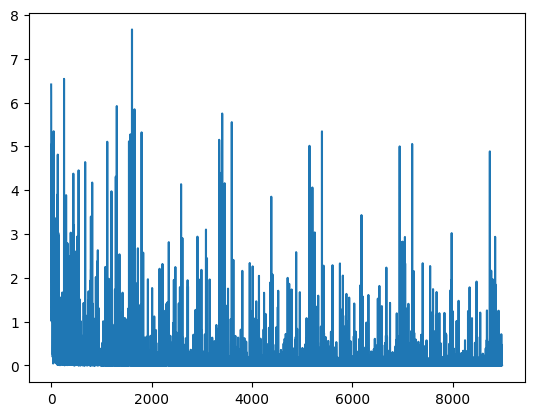

In [20]:
plt.plot(loss_log)

In [21]:
i = 0
y_true_ = y_true[i].reshape(-1, 10) # データ数xクラス数
X = images[i].reshape(-1, 64) # データ数x特徴量数

# Zの計算(Z=X*W^t+b)
Z = X@W.T + b  # 行列の積は@演算子を使う
Z

tensor([[11.1533, -9.4448, -3.0999, -3.1529, -2.5468, -0.1978, -2.1652, -0.8860,
          0.0209,  1.7797]], grad_fn=<AddBackward0>)

In [22]:
y_pred = softmax(Z)
y_pred

tensor([[9.9988e-01, 1.1331e-09, 6.4543e-07, 6.1213e-07, 1.1222e-06, 1.1755e-05,
         1.6436e-06, 5.9067e-06, 1.4629e-05, 8.4923e-05]],
       grad_fn=<DivBackward0>)

In [23]:
y_true_

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [24]:
loss = cross_entropy(y_true_, y_pred)
loss

tensor(0.0001, grad_fn=<DivBackward0>)

In [25]:
# lossは下記と等しい
-np.log(0.0620)

2.7806208939370456

In [26]:
loss.backward()

In [27]:
W.grad.shape

torch.Size([10, 64])

In [28]:
b.grad.shape

torch.Size([1, 10])

# mini-batch学習

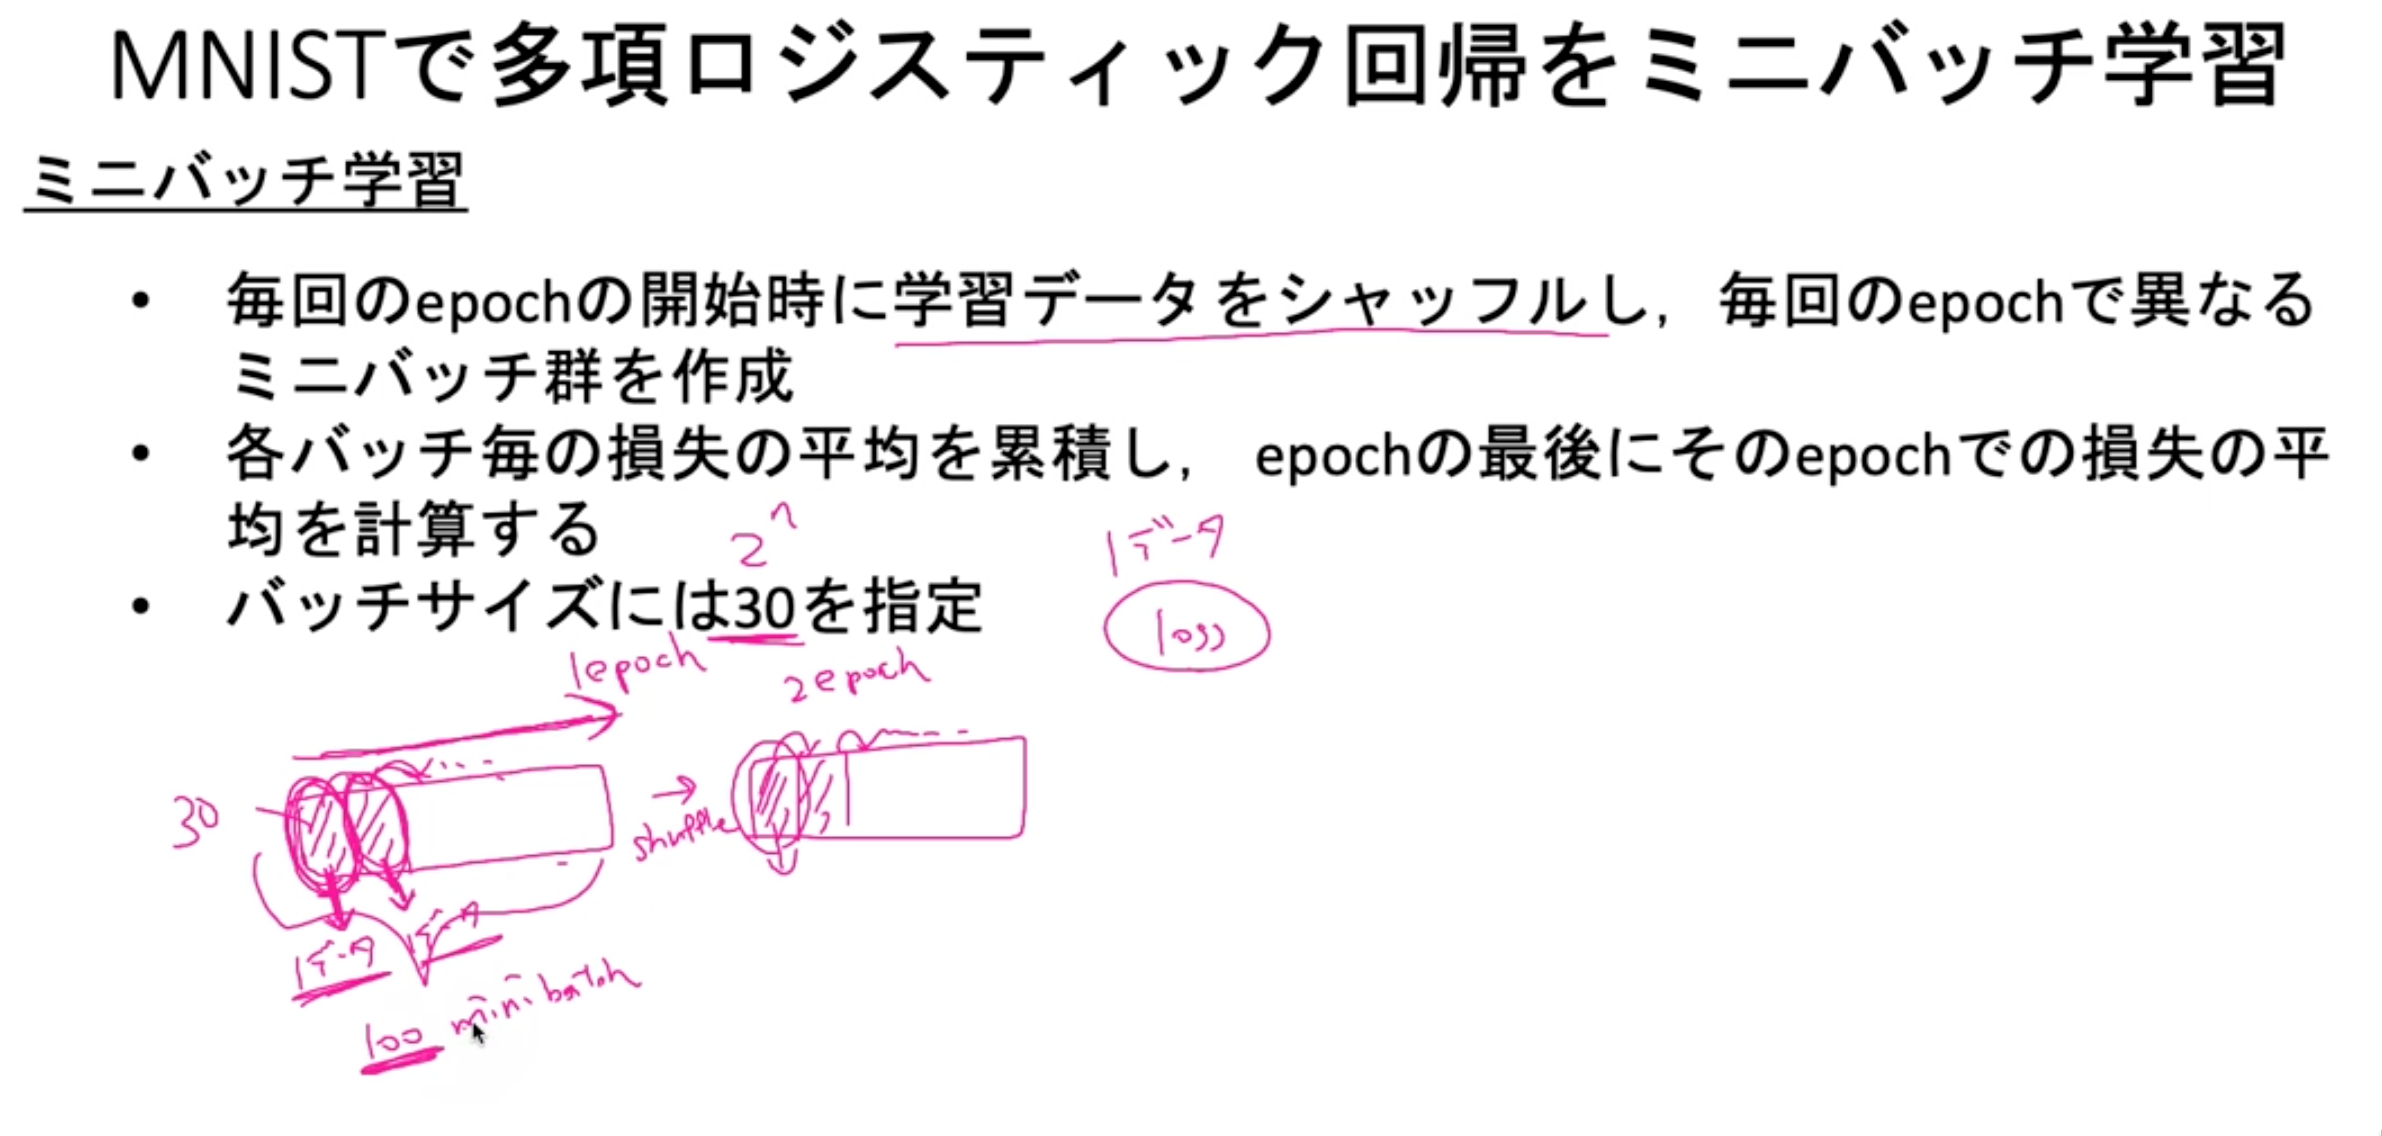

In [51]:
# 説明変数(images)と目的変数(target)のデータ自体をシャッフルするのではなく、各indexをシャッフルすることで学習データをシャッフルする
np.random.permutation(list(range(len(target))))

array([   4, 1342, 1556, ..., 1260, 1491, 1784])

In [52]:
# バッチサイズが30の場合、60個のミニバッチを作る必要がある
batch_size = 30
num_batches = np.ceil(len(target) /batch_size).astype(int)
num_batches

60

In [53]:
# mini batch作成
shuffled_indcies = np.random.permutation(len(target))
i = 2
start = i * batch_size
end = start + batch_size
shuffled_indcies = shuffled_indcies[start:end]
shuffled_indcies

array([  55, 1625,  140, 1603,  425,  282,  818, 1610, 1213, 1333, 1591,
        166,  118,  729,  741,  248, 1427,  243,  687,  387,    5, 1215,
        363,  554,  142,  835, 1326,  412,  595,  178])

In [54]:
loss_log = []

# パラメータ初期化
W = torch.rand((10, 64), requires_grad=True)  # 出力 x 入力
b = torch.rand((1, 10), requires_grad=True)  # 1 x 出力

# バッチサイズとミニバッチの個数を設定
batch_size = 30
num_batches = np.ceil(len(target) /batch_size).astype(int)

# for文で学習ループ作成
for epoch in range(5):
    shuffled_indices = np.random.permutation(len(target))
    running_loss = 0
    for i in range(num_batches):

        # mini batch作成
        start = i * batch_size
        end = start + batch_size
        batch_indices = shuffled_indcies[start:end]
        
        # 入力データXおよび教師ラベルのYを作成
        y_true_ = y_true[batch_indices, :] # データ数xクラス数
        X = images[batch_indices, :] # データ数x特徴量数

        # debug: pdbはPython　debuger　
        # pdb.set_trace() でここの行まで止めることができる
        # c で次のイテレーションに回す
        # exit で抜ける
        # import pdb; pdb.set_trace()
        
        # Zの計算(Z=X*W^t+b)
        Z = X@W.T + b  # 行列の積は@演算子を使う

        # softmaxで予測計算
        y_pred = softmax(Z)

        # 損失計算
        loss = cross_entropy(y_true_, y_pred)
        loss_log.append(loss.item())  # lossはtensorの形になっているので.itemで値だけ取るようにする
        running_loss += loss.item()

        # 勾配計算
        loss.backward()

        # パラメータ更新
        with torch.no_grad():
            W -= learning_rate * W.grad
            b -= learning_rate * b.grad

        # 勾配初期化
        W.grad.zero_()
        b.grad.zero_()

    # 損失ログの出力
    print(f'epoch {epoch+1}: {running_loss/num_batches} ')

epoch 1: nan 
epoch 2: nan 
epoch 3: nan 
epoch 4: nan 
epoch 5: nan 


In [55]:
loss_log = []
batch_size = 30
num_batches = np.ceil(len(target) / batch_size).astype(int)
# 3. パラメータの初期化
W = torch.rand((10, 64), requires_grad=True) # 出力x入力
b = torch.rand((1, 10), requires_grad=True) # 1 x 出力
# 5. for文で学習ループ作成
for epoch in range(5):
    shuffled_indices = np.random.permutation(len(target))
    running_loss = 0
    for i in range(num_batches):

        # mini batch作成
        start = i * batch_size
        end = start + batch_size
        batch_indices = shuffled_indices[start:end]
        # 6. 入力データXおよび教師ラベルのYを作成
        y_true_ = y_true[batch_indices, :] # データ数xクラス数
        X = images[batch_indices, :] # データ数 x 特徴量数
        # ブレークポイントを設置
        # import pdb; pdb.set_trace()
        # debug: pdbはPython　debuger　
        # pdb.set_trace() でここの行まで止めることができる
        # c で次のイテレーションに回す
        # exit で抜ける
        # import pdb; pdb.set_trace()

        # 7. Z計算
        Z = X@W.T + b

        # 8. softmaxで予測計算
        y_pred = softmax(Z)

        # 9. 損失計算
        loss = cross_entropy(y_true_, y_pred)
        loss_log.append(loss.item())
        running_loss += loss.item()
        
        # 10. 勾配計算
        loss.backward()

        # 11. パラメータ更新
        with torch.no_grad():
            W -= learning_rate * W.grad
            b -= learning_rate * b.grad

        # 12. 勾配初期化
        W.grad.zero_()
        b.grad.zero_()

    # 13. 損失ログ出力
    print(f'epoch: {epoch+1}: {running_loss/num_batches}')

epoch: 1: 2.5631367286046345
epoch: 2: 1.1836374084154764
epoch: 3: 0.7616411755482356
epoch: 4: 0.5753634020686149
epoch: 5: 0.47387110044558844


In [56]:
# accuracyを求める
X = torch.tensor(images, dtype=torch.float32)
Z = X@W.T + b
y_pred = softmax(Z)
torch.sum(torch.argmax(y_pred, dim=-1) == torch.argmax(y_true, dim=-1)) / y_true.shape[0]

/tmp/ipykernel_834/403681491.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(images, dtype=torch.float32)


tensor(0.8904)

# 学習データと検証データ作成

学習データと検証データ作成

- sklearn.model_selection.train_test_splitを使用
- 学習データと検証データを8:2で分割
- それぞれのログを記録し、学習曲線を確認できるようにする
- 毎epochごとに検証データのAccuracyを計算する

In [58]:
# データロード
dataset = datasets.load_digits()
images = dataset['images']
target = dataset['target']

# 学習/検証データ分割
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(images, target, test_size=0.2, random_state=42)

In [59]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(1437, 8, 8)
(360, 8, 8)
(1437,)
(360,)


In [60]:
# 前処理
from torch.nn import functional as F

# 2-1 モデルのone-hot　encoding
# ｔａｒｇｅｔのonehotでラベル化
y_train = F.one_hot(torch.tensor(y_train), num_classes=10)
y_val = F.one_hot(torch.tensor(y_val), num_classes=10)
# imagesのtensor化
X_train = torch.tensor(X_train, dtype=torch.float32).reshape(-1, 64)
X_val = torch.tensor(X_val, dtype=torch.float32).reshape(-1, 64)

# 2-2 画像の標準化
X_train_mean = X_train.mean()
X_train_std = X_train.std()
X_train = (X_train - X_train_mean) / X_train_std
X_val = (X_val - X_train_mean) / X_train_std

In [61]:
loss_log = []

# パラメータ初期化
W = torch.rand((10, 64), requires_grad=True)  # 出力 x 入力
b = torch.rand((1, 10), requires_grad=True)  # 1 x 出力

# バッチサイズとミニバッチの個数を設定
batch_size = 30
num_batches = np.ceil(len(y_train) /batch_size).astype(int)

# ログ
train_losses = []
val_losses = []
val_accuracies = []

# for文で学習ループ作成
for epoch in range(30):
    shuffled_indices = np.random.permutation(len(y_train))
    running_loss = 0
    for i in range(num_batches):

        # mini batch作成
        start = i * batch_size
        end = start + batch_size
        batch_indices = shuffled_indices[start:end]
        
        # 入力データXおよび教師ラベルのYを作成
        y_true_ = y_train[batch_indices, :] # データ数xクラス数
        X = X_train[batch_indices, :] # データ数 x 特徴量数
        
        # Zの計算(Z=X*W^t+b)
        Z = X@W.T + b  # 行列の積は@演算子を使う

        # softmaxで予測計算
        y_pred = softmax(Z)

        # 損失計算
        loss = cross_entropy(y_true_, y_pred)
        loss_log.append(loss.item())  # lossはtensorの形になっているので.itemで値だけ取るようにする
        running_loss += loss.item()

        # 勾配計算
        loss.backward()

        # パラメータ更新
        with torch.no_grad():
            W -= learning_rate * W.grad
            b -= learning_rate * b.grad

        # 勾配初期化
        W.grad.zero_()
        b.grad.zero_()

    # validation:同様に出力結果Z,softmax計算,損失計算,最後にAccuracyを計算。validationでは勾配計算をする必要がない
    # また、学習データではミニバッチでデータを分割し実施していたが、検証データでは一括で実施していることに注意
    with torch.no_grad():
        Z_val = X_val@W.T + b
        y_pred_val = softmax(Z_val)
        val_loss = cross_entropy(y_val, y_pred_val)
        # Accuracy
        val_accuracy = torch.sum(torch.argmax(y_pred_val, dim=-1) == torch.argmax(y_val, dim=-1)) / y_val.shape[0]

    train_losses.append(running_loss/num_batches)
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy.item())

    # 損失ログの出力
    print(f'epoch {epoch+1}: {running_loss/num_batches}, val loss: {val_loss.item()}, val accuracy: {val_accuracy}')

epoch 1: 2.1082517554362616, val loss: 1.3486132621765137, val accuracy: 0.5277777910232544
epoch 2: 1.1169566201666992, val loss: 0.8887823224067688, val accuracy: 0.730555534362793
epoch 3: 0.7906389161944389, val loss: 0.6764599084854126, val accuracy: 0.8027777671813965
epoch 4: 0.6250904264549414, val loss: 0.5562788844108582, val accuracy: 0.855555534362793
epoch 5: 0.5258481403191885, val loss: 0.4826611876487732, val accuracy: 0.8638888597488403
epoch 6: 0.4588984629760186, val loss: 0.4314853549003601, val accuracy: 0.8805555701255798
epoch 7: 0.409964671668907, val loss: 0.3907472491264343, val accuracy: 0.894444465637207
epoch 8: 0.3731023358802001, val loss: 0.35804420709609985, val accuracy: 0.9027777910232544
epoch 9: 0.3433160896723469, val loss: 0.33303302526474, val accuracy: 0.9138888716697693
epoch 10: 0.3197657826046149, val loss: 0.3137942850589752, val accuracy: 0.9166666865348816
epoch 11: 0.29956089177479345, val loss: 0.2969335913658142, val accuracy: 0.9166666

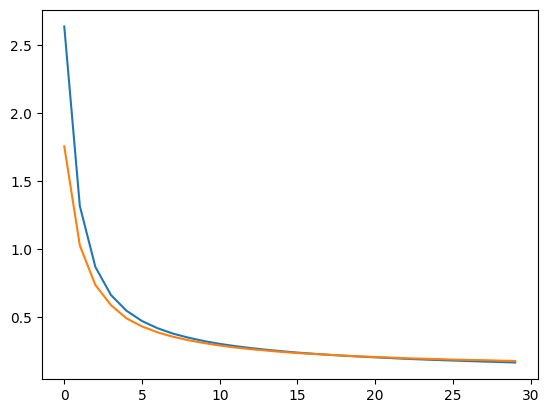

In [52]:
plt.plot(train_losses)
plt.plot(val_losses)